In [1]:
import xarray as xr
import numpy as np
import xmitgcm
import sandbox as sb

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tm4 = [-sb.degMinSec2decimal(70,54.0876), 
       sb.degMinSec2decimal(39,50.8542)]
at  = [-sb.degMinSec2decimal(70,53.1670), 
       sb.degMinSec2decimal(39,57.1500)]
line= sb.gcspace(tm4, at, npts=10)
print(line)

[[-70.90146, -70.90006708378215, -70.89867378182157, -70.89728009388173, -70.89588601972592, -70.89449155911723, -70.89309671181859, -70.89170147759275, -70.89030585620232, -70.88890984740969, -70.88751345097712, -70.88611666666667], [39.84757, 39.85710925340228, 39.866648474339314, 39.8761876628, 39.885726818773186, 39.89526594224777, 39.90480503321258, 39.914344091656496, 39.92388311756834, 39.933422110936995, 39.94296107175126, 39.9525]]


In [5]:
data_dir = '/home/ivana/regionalgcm/tutorial_global_oce_latlon/run'
grid_dir = data_dir

In [6]:
ds = xmitgcm.open_mdsdataset(data_dir, 
                             prefix=['ssp', 'T'], 
                             iters=[20])
ds = ds.squeeze()
ds = ds.isel(Z=0)

In [7]:
ds = ds.where(ds.maskC==True, np.nan)
ds

<xarray.Dataset>
Dimensions:   (YC: 40, XC: 90, XG: 90, YG: 40, Zp1: 16, Zu: 15, Zl: 15)
Coordinates: (12/34)
    iter      int64 20
    time      timedelta64[ns] 00:00:20
  * XC        (XC) >f4 2.0 6.0 10.0 14.0 18.0 ... 342.0 346.0 350.0 354.0 358.0
  * YC        (YC) >f4 -78.0 -74.0 -70.0 -66.0 -62.0 ... 66.0 70.0 74.0 78.0
  * XG        (XG) >f4 0.0 4.0 8.0 12.0 16.0 ... 340.0 344.0 348.0 352.0 356.0
  * YG        (YG) >f4 -80.0 -76.0 -72.0 -68.0 -64.0 ... 64.0 68.0 72.0 76.0
    ...        ...
    maskS     (YG, XC) bool dask.array<chunksize=(40, 90), meta=np.ndarray>
    rhoRef    >f4 1.025e+03
    dxF       (YC, XC) >f4 dask.array<chunksize=(40, 90), meta=np.ndarray>
    dyF       (YC, XC) >f4 dask.array<chunksize=(40, 90), meta=np.ndarray>
    dxV       (YG, XG) >f4 dask.array<chunksize=(40, 90), meta=np.ndarray>
    dyU       (YG, XG) >f4 dask.array<chunksize=(40, 90), meta=np.ndarray>
Data variables:
    T         (YC, XC) float32 dask.array<chunksize=(40, 90), meta=np.ndarray>
    ihop_ssp  (YC, XC) float32 dask.array<chunksize=(40, 90), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=[2...

# PyInterp type interpolation

In [8]:
import pyinterp
mesh = pyinterp.RTree()

In [9]:
#python nuissances to make the interp work
xc=[]; yc=[]
for i in range(90):
    if i < 40:
        xc.append(ds.XC.values.tolist())
    yc.append(ds.YC.values.tolist())
xc = np.array( xc )
yc = np.array( yc ).T
ssp= np.array( ds.ihop_ssp.values.tolist())

In [10]:
mesh.packing( np.vstack( (xc.ravel(), yc.ravel()) ).T,
             ssp.ravel() )

In [11]:
idw_ssp, idw_neighbors = mesh.inverse_distance_weighting(
    np.vstack((line[0],line[1])).T, 
    within = True,
    #radius = 100000, #100 km radius
    k=11
)

In [12]:
rbf_ssp, rbf_neighbors = mesh.radial_basis_function(
    np.vstack((line[0],line[1])).T,
    #radius=1000000,
    within=True,  # Extrapolation is forbidden
    k=11  # We are looking for at most 11 neighbours
)

# Visualize pyinterp results

In [13]:
import cartopy.crs
import cartopy.mpl.ticker

In [14]:
xc , yc = np.meshgrid(ds.XC, ds.YC)

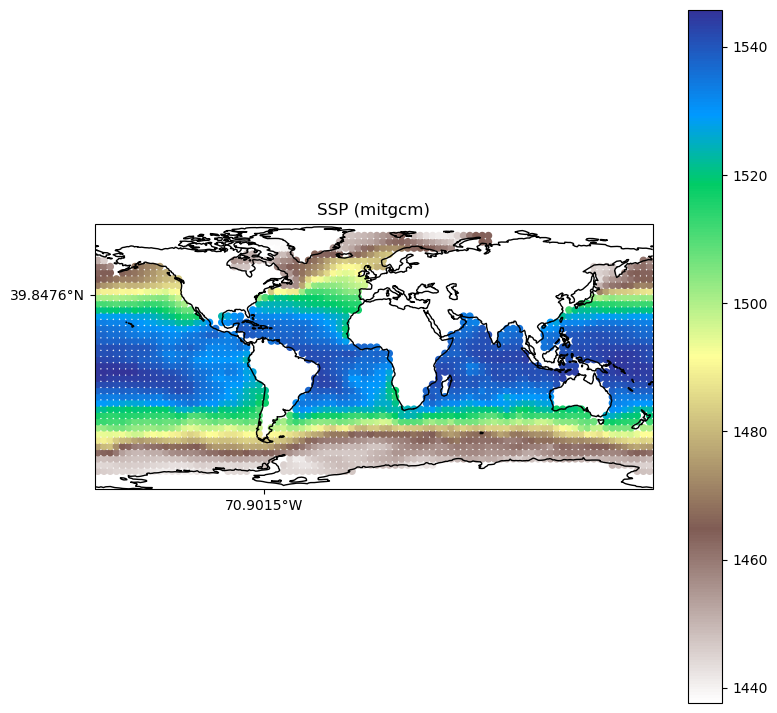

In [19]:
fig = plt.figure(figsize=(9, 9))
lon_formatter = cartopy.mpl.ticker.LongitudeFormatter(
    zero_direction_label=True)
lat_formatter = cartopy.mpl.ticker.LatitudeFormatter()

ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
im=ax.scatter(   xc,
              yc,
              c=ds.ihop_ssp,
              cmap='terrain_r',
              s=20,
              transform=cartopy.crs.PlateCarree())
ax.coastlines()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(line[0][0], line[0][-1], 10.0))
ax.set_yticks(np.arange(line[1][0], line[1][-1], 10.0))
ax.set_title('SSP (mitgcm)')

#im.set_clim(min(rbf_ssp), max(idw_ssp))
plt.colorbar(im)

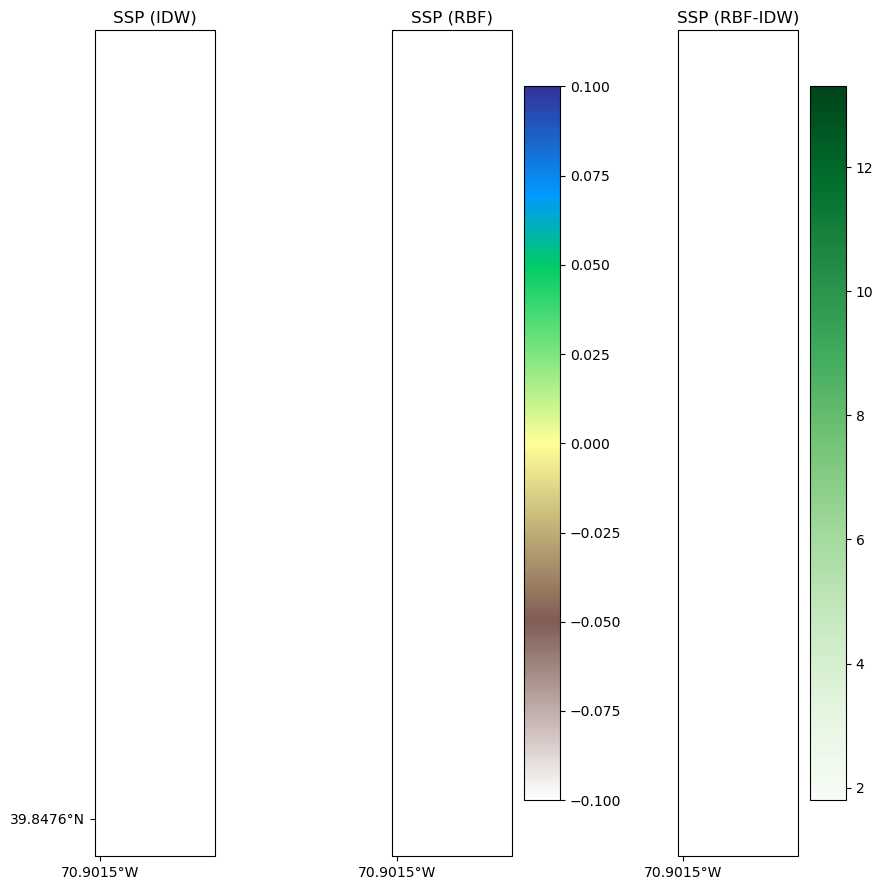

In [16]:
fig = plt.figure(figsize=(9, 9))
lon_formatter = cartopy.mpl.ticker.LongitudeFormatter(
    zero_direction_label=True)
lat_formatter = cartopy.mpl.ticker.LatitudeFormatter()

ax = fig.add_subplot(131, projection=cartopy.crs.PlateCarree())
ax.scatter(   line[0],
              line[1],
              c=idw_ssp,
              cmap='terrain_r',
              s=35,
              transform=cartopy.crs.PlateCarree())
ax.coastlines()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(line[0][0], line[0][-1], 10.0))
ax.set_yticks(np.arange(line[1][0], line[1][-1], 10.0))
ax.set_title('SSP (IDW)')

ax = fig.add_subplot(132, projection=cartopy.crs.PlateCarree())
im = ax.scatter(   line[0],
              line[1],
              c=rbf_ssp,
              cmap='terrain_r',
              s=35,
              transform=cartopy.crs.PlateCarree())
ax.coastlines()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(line[0][0], line[0][-1], 10.0))
ax.set_title('SSP (RBF)')
im.set_clim(min(rbf_ssp), max(idw_ssp))
plt.colorbar(im)

ax = fig.add_subplot(133, projection=cartopy.crs.PlateCarree())
im = ax.scatter(   line[0],
              line[1],
              c=np.abs(rbf_ssp-idw_ssp),
              cmap='Greens',
              s=35,
              transform=cartopy.crs.PlateCarree())
ax.coastlines()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(line[0][0], line[0][-1], 10.0))
ax.set_title('SSP (RBF-IDW)')
im.set_clim(min(rbf_ssp), max(idw_ssp))
im.set_clim(1.8, 13.3)
plt.colorbar(im)

fig.tight_layout()
fig.show()

values of interp aren't even close to the values of ssp in the ocean. Off by an order of magnitude!

In [20]:
mesh.query(np.array([[-70.9,39.3]]))

(array([[164200.01517219, 305967.51209805, 309303.25465429,
         398173.90018384]]),
 array([[1510.25195312, 1502.31860352,           nan,           nan]]))